In [1]:
'''PROBLEM SETUP'''
import gen_wind_field
import dynamics
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

def x_start(i):
    global n
    return (i - 1) * (n)


def x_end(i):
    global n
    return i * (n)


def u_start(i):
    global n
    return u_shift + (i - 1) * (m)


def u_end(i):
    global n
    return u_shift + i * (m)


# def test():
n = 6  # get the state dimension
m = 3  # get the control dimension
mass = 1
g = 9.81
rho = 1.225
s = 1
Cd = 0.05
x0 = np.array([100.0, 200.0, 20.0, 10, 0.0, 0.0])
x_goal = np.array([400.0, 200.0, 20.0, 10.0, 0.0, 0.0])
t_goal = 30.0
t_step = 0.25
t_array = np.arange(0.0,t_goal+t_step,t_step)
N = t_array.size

xlb = np.array([0, 0, 0, 0, - np.pi / 4.0, - np.pi / 2.0])
xub = np.array([500, 500, 50, 20, np.pi / 4.0, np.pi / 2.0])
ulb = np.array([-1, - np.pi / 4.0, 0])
uub = np.array([1, np.pi / 4.0, m * g])
bounds = [[xlb[0], xub[0]], [xlb[1], xub[1]]]
resolution = [10, 10]
mu = [0.0, 0.0, 0.0]
sigma = [0.0, 0.0, 0.0]
thermal_list = [[200, 300]]
wind = gen_wind_field.WindField(bounds, resolution, mu, sigma, thermal_list)
vehicle_dyn = dynamics.Dynamics(mass, g, rho, s, Cd, wind)



# Creating the nominal trajectory
#for i in range(N):
x1 = np.vstack(np.linspace(x0[0], x_goal[0], N, endpoint=True)) # x
x2 = np.vstack(np.linspace(x0[1], x_goal[1], N, endpoint=True)) # y
x3 = np.vstack(np.linspace(x0[2], x_goal[2], N, endpoint=True)) # z
x4 = np.vstack(np.linspace(x0[3], x_goal[3], N, endpoint=True)) # V
x5 = np.vstack(np.linspace(x0[4], x_goal[4], N, endpoint=True)) # gamma
x6 = np.vstack(np.linspace(x0[5], x_goal[5], N, endpoint=True)) # psi

x_ref = np.hstack((x1,x2,x3,x4,x5,x6))
u3 = np.zeros((x1.size,1))
for i in range(N):
    Wx, Wy, Wz = wind.get_wind_vel(np.array(np.hstack([x1[i], x2[i], x3[i]])))
    x1d = x3[i] * np.cos(x4[i]) * np.cos(x5[i]) + Wx
    x2d = x3[i] * np.cos(x4[i]) * np.sin(x5[i]) + Wy
    x3d = - x3[i] * np.sin(x4[i]) + Wz
    dWdx = wind.get_wind_grad(np.array(np.hstack([x1[i], x2[i], x3[i]])))
    dWdt = np.dot(dWdx,np.array(np.hstack([x1d, x2d])))
    u1 = m*g / ( 0.5 * rho * x4 ** 2 * s)
    u2 = -1 * (x4 - (Cd * 0.5 * rho * x4 ** 2 * s) - m * g * np.sin(x4) - m * dWdt[0] * np.cos(x5) * np.cos(x6) - \
           m * dWdt[1] * np.cos(x5) * np.sin(x6) + m * dWdt[2] * np.sin(x5))
    u3[i] = np.random.rand(1)
    #np.arcsin((((m * x4 * np.cos(x5))) - (m * dWdt[0] * np.sin(x6) - m * dWdt[1] * np.cos(x6)))/ (u1 * ( 0.5 * rho * x4 ** 2 * s)))

u_ref = np.hstack((u1,u2,u3))

# INPUT
# State(N), Control

# Define final condition
goal_state = np.array([400.0, 200.0, 20.0, 10.0, 0.0, 0.0])

"""
Set up initial state and control parameters
state = x, y, z, V, gamma, psi
control = Cl, phi, T
"""
x, y, z, V, gamma, psi = (2, 3, 5, 5, np.pi / 36, np.pi / 9)
Cl, phi, T = (0.8, np.pi / 18, 0.8)
state = np.array([x, y, z, V, gamma, psi])
control = np.array([Cl, phi, T])
# function var = solveLOCP(var_k)


state = np.reshape(x_ref, (n * N, 1))  # np.vstack([state,x_k[i],y_k[i],z_k[i],V_k[i],gamma_k[i],psi_k[i]])
control = np.reshape(u_ref, (m * N, 1))  # np.vstack([u_k1[i],u_k2[i],u_k3[i]])

z_old = np.vstack([state, control])
# Define trust regions
epsTrust = 10
# SET UP INDEXING FUNCTIONS
u_shift = n * N

n_constraints = (n) * N
C = np.zeros([n_constraints, (n + m) * N])  # % Cvx accepts equality constraints in the form of C*var=d
# and bounds of type lb <= var <= ub.
# C will contain all the linearized dynamical
# constraints

d = np.zeros([n_constraints, 1])
lb = np.zeros([(n + m) * N, 1])
ub = np.zeros([(n + m) * N, 1])
h = t_step

dyn = dynamics.Dynamics(1, 9.8, 1.225, 1, 0.05,
               gen_wind_field.WindField([[0, 10], [0, 10]], [10, 10], [0, 0, 0], [1, 1, 1], [[2, 7]]))

for i in range(1, N):  # Dynamic constraints
    state_k = x_ref[i]  # np.concatenate([x_k[i], y_k[i], z_k[i], V_k[i], gamma_k[i], psi_k[i]])
    control_k = u_ref[i]  # np.concatenate([u_k1[i],u_k2[i],u_k3[i]])

    f_Dyn = dyn.f(state_k, control_k)
    DxyfDyn_k = dyn.dfdx(state_k, control_k)
    DufDyn_k = dyn.dfdu(state_k, control_k)

    C[x_start(i):x_end(i), x_start(i + 1):x_end(i + 1)] = np.eye(n)
    C[x_start(i):x_end(i), x_start(i):x_end(i)] = - (h * DxyfDyn_k + np.eye(n))
    C[x_start(i):x_end(i), u_start(i):u_end(i)] = - h * DufDyn_k
    d[x_start(i):x_end(i), 0] = (f_Dyn - np.dot(DxyfDyn_k, state_k) - np.dot(DufDyn_k, control_k)) * h
C[x_start(N):x_end(N), x_start(1):x_end(1)] = np.eye(n)
d[x_start(N):x_end(N), 0] = x0

# there could be a bug here, check the control doesnt overlap the state
lb = -1000 * np.ones([(n + m) * N, 1])
ub = 1000 * np.ones([(n + m) * N, 1])
z0 = np.zeros([(n + m) * N, 1])
u_lb, u_ub = -10, 10

lb[u_shift:u_shift + m * N] = u_lb * np.ones([m * N, 1])  # set lower bound for control
ub[u_shift:u_shift + m * N] = u_ub * np.ones([m * N, 1])  # set upper bound for control

# TARGET STATE FOR z
for i in range(1, N):
    z0[(i - 1) * n:i * n] = np.vstack(goal_state)
z0.reshape(z0.shape[0])

# Cost
M = np.zeros(((n + m) * N, (n + m) * N))
for i in range(1, N):
    if (i < N):
        M[x_start(i): x_end(i), x_start(i): x_end(i)] = np.eye(n) * 10
    else:
        M[x_start(i): x_end(i), x_start(i): x_end(i)] = np.eye(n) * 100

    M[u_start(i): u_end(i), u_start(i): u_end(i)] = np.eye(m)

# SET CONSTRAINTS FOR TRUST REGION
# set the box constraints for x and u
# lb_trust = -1000 * np.ones(
#     [(n + m) * N, 1])  # % x is the first n*num_steps entries, and u is the remaining m*num_steps entries.
# ub_trust = 1000 * np.ones([(n + m) * N, 1])

rho = 50.0
lb_trust = z_old - rho
# lb = np.maximum(lb, lb_trust)
ub_trust = z_old + rho
# ub = np.minimum(ub, ub_trust)

#C = cvxopt.matrix(C)
z = cp.Variable(((n+m)*N,1))
#zf = cp.Parameter((n+m)*N,z0[:,0])
#d = cvxopt.matrix(d)
zTMz = cp.quad_form((z-z0), M)
objective = cp.Minimize(zTMz)
constraints = [C@z==d]
prob = cp.Problem(objective, constraints)

# The optimal objective value is returned by `prob.solve()`.
result = prob.solve()
# The optimal value for x is stored in `x.value`.
# print(z.value)

x_o = np.zeros([N, 1])
y_o = np.zeros([N, 1])
z_o = np.zeros([N, 1])
V_o = np.zeros([N, 1])
gamma_o = np.zeros([N, 1])
psi_o = np.zeros([N, 1])
for i in range(0, N):  # Dynamic constraints
    x_o[i] = z.value[x_start(i + 1)]
    y_o[i] = z.value[x_start(i + 1) + 1]
    z_o[i] = z.value[x_start(i + 1) + 2]
    V_o[i] = z.value[x_start(i + 1) + 3]
    gamma_o[i] = z.value[x_start(i + 1) + 4]
    psi_o[i] = z.value[x_start(i + 1) + 5]

plt.plot(x_o,y_o)
plt.xlabel('x'),plt.ylabel('y')
plt.show()
print('finish')

<Figure size 640x480 with 1 Axes>

finish


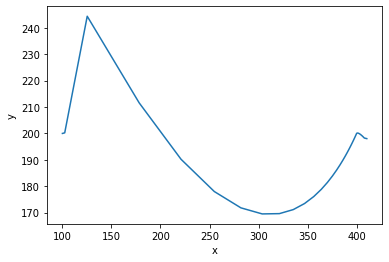

In [3]:
plt.plot(x_o,y_o)
plt.xlabel('x'),plt.ylabel('y')
plt.show()